In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
url = 'http://archive.ics.uci.edu/ml/' \
      'machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
        'Weight', 'Acceleration', 'Model Year', 'Origin']

numerical_columns = ['Cylinders', 'Displacement', 'Horsepower',
        'Weight', 'Acceleration']

df = pd.read_csv(url,names=column_names, sep=' ', comment='\t',na_values = "?",skipinitialspace=True)

# Drop the NA rows
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)    # assigning a new default integer index to the DataFrame

# Convert The Model Year column
boundries = torch.tensor([73,76,79])
v = torch.tensor(df['Model Year'].values)
df['Model Year'] = torch.bucketize(v,boundries,right=True)

# One-Hot-Encoding for the 'Original' column
origin_encoded = one_hot(torch.tensor((df['Origin']-1).values),num_classes=df['Origin'].nunique())[:,1:]
data = torch.cat([torch.tensor(df.drop(columns='Origin').values),origin_encoded],dim=1)
column_names_encoded = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
        'Weight', 'Acceleration', 'Model Year', 'Europe','Japan']
df = pd.DataFrame(data,columns=column_names_encoded)

# Split our data
df_train, df_test = train_test_split(df,test_size=0.8,random_state=123)

# Sdandarize it
for col in numerical_columns:
    mean = df_train[col].mean()
    std = df_train[col].std()
    df_train[col] = (df_train[col] - mean) / std
    df_test[col] = (df_test[col] - mean) / std

# Devide the data
X_train = torch.tensor(df_train.iloc[:,1:].values).float()
X_test = torch.tensor(df_test.iloc[:,1:].values).float()
y_train = torch.tensor(df_train.iloc[:,0].values).float()
y_test = torch.tensor(df_test.iloc[:,0].values).float()

df_train.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan
3,16.0,1.629454,1.192495,1.373011,0.629638,-1.470879,0.0,0.0,0.0
56,24.0,-0.779976,-0.748803,-0.226722,-0.812878,-0.048960,0.0,0.0,1.0
304,28.8,0.424739,-0.138971,0.354999,-0.416967,-1.755263,3.0,0.0,0.0
233,26.0,-0.779976,-0.911425,-0.808443,-0.829115,1.047949,2.0,0.0,1.0
51,30.0,-0.779976,-1.002900,-0.779357,-1.078901,-0.455222,0.0,1.0,0.0


In [3]:
torch.manual_seed(123)
data_train = DataLoader(dataset=TensorDataset(X_train,y_train), shuffle=True, batch_size=8)
data_test = DataLoader(dataset=TensorDataset(X_test,y_test), shuffle=True, batch_size=8)

In [4]:
class PFECModel(nn.Module):

    def __init__(self,n_input,n_output):
        super(PFECModel, self).__init__()    # Call the parent class's __init__()
        self.n_input = n_input
        self.n_output = n_output
        self.Seq = nn.Sequential(
            nn.Linear(self.n_input,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,self.n_output)
        )

    def forward(self,x):
        return self.Seq(x)
    
model = PFECModel(8,1)

        

In [5]:
loss_fn = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epochs = 200

/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasti

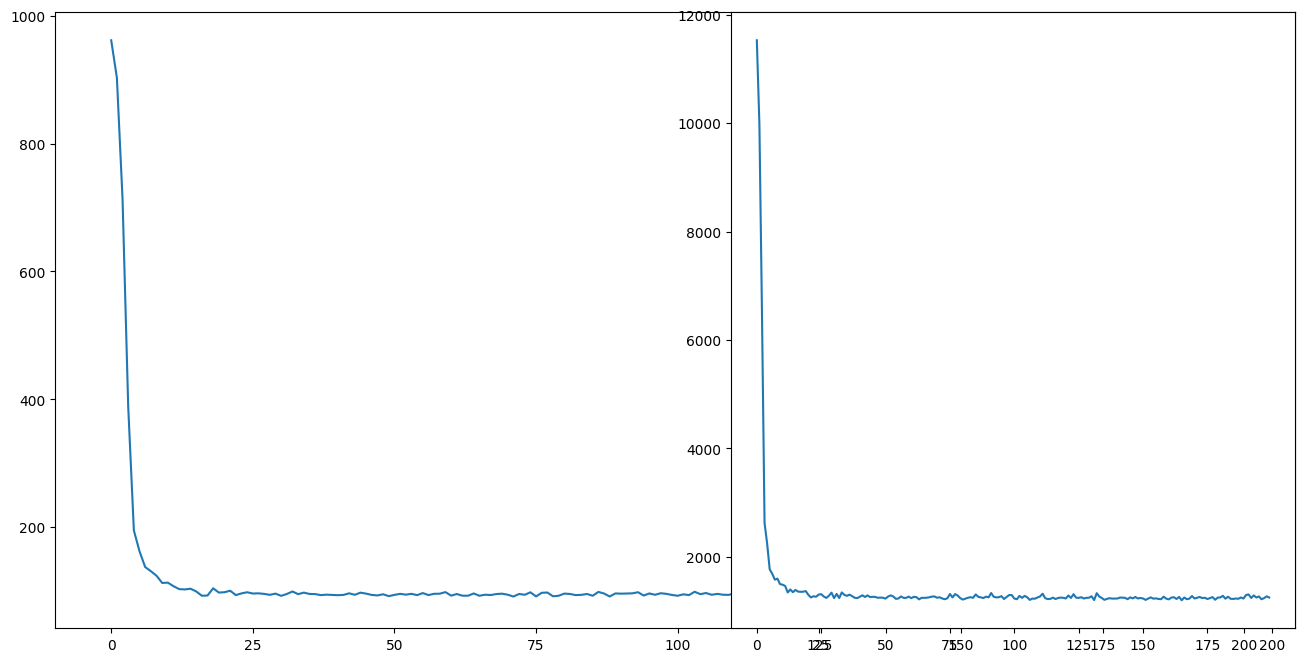

Train MSE: 58.9395
Train MAE: 6.4233

Test MSE: 65.8761
Test MAE: 6.7841


/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([78, 1])) that is different to the input size (torch.Size([78])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([314, 1])) that is different to the input size (torch.Size([314])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/fatnaoui/miniforge3/envs/PFEC/lib/python3.13/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([78, 1])) that is different to the input size (torch.Size([78])). This will likely lead to incorrect results due to br

In [6]:
losses_train = [0 for i in range(epochs)]
losses_test = [0 for i in range(epochs)]
for i in range(epochs):
    for (x_batch,y_batch) in data_train:
        pred = model(x_batch)
        loss = loss_fn(y_batch,pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses_train[i] += loss.item()
    losses_train[i] /= len(y_batch)
    with torch.no_grad():
        for (x_batch,y_batch) in data_test:
            pred = model(x_batch)
            loss = loss_fn(y_batch,pred)
            losses_test[i] += loss.item()
        losses_test[i] /= len(y_batch)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
ax.plot(losses_train)
ax = fig.add_subplot(1,2,2)
ax.plot(losses_test)
plt.show()

with torch.no_grad():
    pred_train = model(X_train)
    loss_train = loss_fn(y_train,pred_train)
    pred_test = model(X_test)
    loss_test = loss_fn(y_test,pred_test)
    print(f'Train MSE: {loss_train.item():.4f}')
    print(f'Train MAE: {nn.L1Loss()(y_train,pred_train).item():.4f}')
    print()
    print(f'Test MSE: {loss_test.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(y_test,pred_test).item():.4f}')


#### Adam Vs SGD optimizer